In [72]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

import re
from pycountry import languages
from langdetect import DetectorFactory, detect_langs
DetectorFactory.seed = 0

import spacy
nlp = spacy.load("en_core_web_sm", disable= ['tagger', 'parser', 'ner'])
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import preprocess_string

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category= UserWarning)

In [2]:
data = pd.read_csv("data/all_songs_data.csv", nrows= 10000)

### Language Detection

In [3]:
df_lang = pd.DataFrame(columns = ["en"])
for ii in data.index:
    try:
        # save probabilities
        for lang in detect_langs(data.loc[ii,"Lyrics"]):
            df_lang.loc[ii, lang.lang] = lang.prob
    except:
        pass

# add to main data frame
data['lang'] = df_lang.idxmax(axis= 1)
    

#### Top 5 Languages

In [4]:
print(data['lang'].value_counts(normalize= True).sort_values(ascending = False).head(5))

lang
en    0.976504
ro    0.006109
es    0.005796
pt    0.001723
de    0.001566
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Percentage of Billboard USA Top 100 Songs\n(in 5 Most Common Languages)')

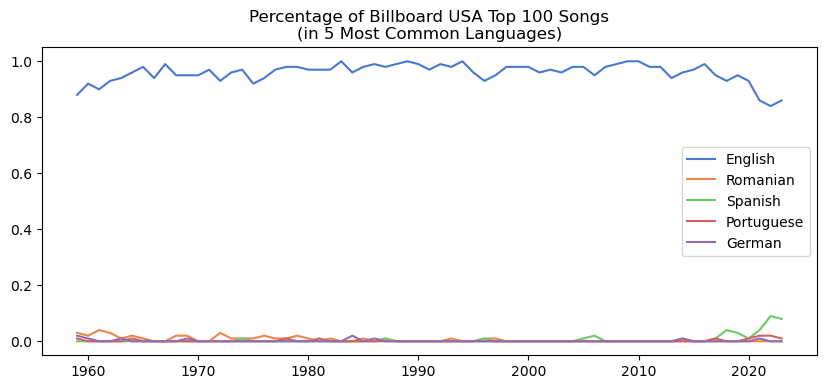

In [5]:
top_5_langs= ['en','ro','es','pt','de']
color_map = sns.color_palette('muted')

fig = plt.figure(figsize= (10,4))
dt_frac_lang= pd.pivot_table(data, index= "Year", columns= "lang", values= "Song Title", 
                        aggfunc= "count")[top_5_langs].fillna(0)/100
for ll,cc in zip(top_5_langs, color_map[:5]):
    plt.plot(dt_frac_lang[ll], color=cc, label = languages.get(alpha_2= ll).name)
plt.legend()
plt.title("Percentage of Billboard USA Top 100 Songs\n(in 5 Most Common Languages)")
# fig.savefig("images/top_5_lang_trend.png")

#### Mis-classification in Languages

The 1959 Fleetwoods song *'Come Softly To Me'* is classified as 71% portugese, 14.2% Somali and only 14% as English. This is because of notes like *Dooby doo dum dum* which our language detection algorithm identifies to be Portugese.

This is an issue to be tackled at a later stage. However, since the song contains very few English words, for now we can proceed as is.

In [6]:
def check_incorrect_language(ss, delimiter= "\n"):
    print(detect_langs(ss))
    print("----\n First 10 lines of song:\n")
    print("\n".join(re.split(delimiter, ss)[:10]))

check_incorrect_language(data.loc[7, "Lyrics"], delimiter= ', dum doo ')

[pt:0.7142843296228, en:0.14285760664171937, so:0.1428566298679429]
----
 First 10 lines of song:

Doo dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo  (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo  (Come softly, darling) Dum dum
dum, dooby doo (Come to me, stay) Dum dum


Similarly, the 1963 Elvis Presley song *'(You're The) Devil In Disguise'* is classfied as 57% English and 43% Afrikaans.

In [7]:
check_incorrect_language(data.loc[468, "Lyrics"], "l |  ")

[en:0.5714272063218119, af:0.42857121085653394]
----
 First 10 lines of song:

You look like an ange
Walk like an ange
Talk like an ange
But I got wise You're the devi
in disguise Oh yes you are The devi
in disguise
You fooled me with your kisses You cheated and you schemed Heaven knows how you lied to me You're not the way you seemed
You look like an ange
Walk like an ange
Talk like an ange


### Length of Songs

In [8]:
data['length'] = winsorize(data['Lyrics'].apply(lambda x: len(x.split(" ")) if isinstance(x, str) else 0), (0.01, 0.01))

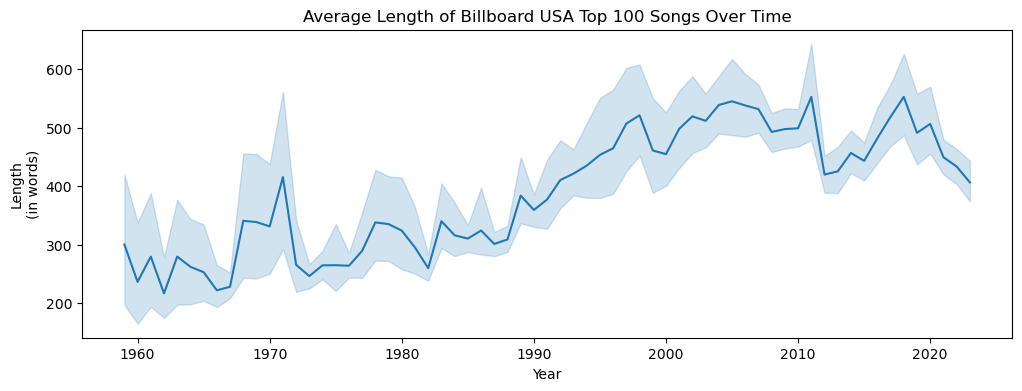

In [59]:
fig = plt.figure(figsize= (12,4))
sns.lineplot(data= data, x= "Year", y= "length")
plt.title("Average Length of Billboard USA Top 100 Songs Over Time");
plt.ylabel("Length\n(in words)");
# fig.savefig("images/song_length_over_time.png")

### Preprocessing using gensim

In [94]:
def remove_punctuation(text):
    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    text = reg_punc.sub(r'', text)
    return text

def remove_stopwords(text):
    return " ".join([ww for ww in text.split() if ww not in stop_words])

def remove_html_url(text):

    # remove html
    reg_html = re.compile(r'<.*?>')
    text = reg_html.sub(r'', text)
    # remove url
    reg_url = re.compile(r'http\S+')
    text = reg_url.sub(r'', text)

    return text

def remove_numbers(text):
    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    text = reg_num.sub(r'', text)
    return text

def remove_special_char(text):
    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    text = reg_spcl.sub(r'', text)
    return text

def remove_emoji(text):
    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_url.sub(r'', text)

    return text

# preprocess given text
def preprocess(text):
    
    # clean text based on given filters
    CUSTOM_FILTERS = [lambda x: x.lower(), remove_punctuation, remove_emoji,
                                remove_html_url, remove_numbers, remove_special_char]
    text = preprocess_string(text, CUSTOM_FILTERS)
    text = " ".join(text)
    
    return text

# lemmatize text using spacy
def lemmatize_text(text):
    return [" ".join([token.lemma_ for token in doc]) for doc in tqdm(nlp.pipe(text, batch_size=32)) ]

stop_words = [remove_punctuation(ww) for ww in stopwords.words('english')]
# add context specific stopwords
stop_words.extend(['verse','chorus','prechorus','instrumental'])

In [95]:
# only keep english songs for now
data = data.query('lang== "en"')
data.drop_duplicates(['Song Title'], keep= 'first', inplace= True)
# create song title to ID mapping
data['Song Title'] = data['Song Title'].fillna('').apply(preprocess)
title_id_map = {value:key for key,value in data['Song Title'].drop_duplicates().reset_index(drop= True).to_dict().items()}
data['Song ID'] = data['Song Title'].map(title_id_map)

data['clean_lyrics'] = data['Lyrics'].fillna('').apply(preprocess)
data['clean_lyrics'] = lemmatize_text(data['clean_lyrics'])
# remove stop words after lemmatization for eg im splits into 'i' and 'm'
data['clean_lyrics'] = data['clean_lyrics'].apply(remove_stopwords)
data['clean_length'] = winsorize(data['clean_lyrics'].apply(lambda x: len(x.split(" ")) if isinstance(x, str) else 0), (0.01, 0.01))

data.drop(['Album URL',"Media",'Song URL'], axis= 1).to_csv("data/preprocessed.csv")

In [63]:
data.query("Artist== 'Taylor Swift'").tail(1)

,Album,Album URL,Artist,Featured Artists,Lyrics,Media,Rank,Release Date,Song Title,Song URL,Writers,Year,lang,length,clean_lyrics,clean_length
6431,Midnights (3am Edition),https://genius.com/albums/Taylor-swift/Midnigh...,Taylor Swift,[],Meet me at midnight [Verse 1] Staring at the ...,"[{'attribution': 'taylorswiftofficial', 'provi...",32,2022-10-21,Lavender Haze,https://genius.com/Taylor-swift-lavender-haze-...,"[{'api_path': '/artists/1177', 'header_image_u...",2023.0,en,332,meet midnight verse staring ceiling oh do nt d...,163


In [66]:
data.query("Artist== 'Taylor Swift'").tail(1)['clean_lyrics'].iloc[0]

'meet midnight verse staring ceiling oh do nt do nt read melancholia prechorus scrutiny yeah oh yeah handle beautifully yeah oh yeah shit new yeah oh yeah chorus feel lavender haze creeping surreal i m damned damn people deal s shit want wanna stay lavender haze verse asking all asking me i m go to bride kinda girl only kinda girl see onenight wife taylor swift liveget tickets low you likeprechorus dizzying yeah oh yeah they re bringing history yeah oh yeah were nt listening yeah oh yeah chorus feel lavender haze creepin surreal i m damned damn people deal s shit want wanna stay lavender haze postchorus lavender haze bridge talk talk viral need love spiral chest desk get desk talk talk viral need love spiral chest desk chorus feel i feel lavender haze creeping surreal i m damned damn people deal no deal s shit want wanna stay lavender haze outro chest desk lavender haze wanna stay wanna stay lavender hazeembed'

C:\Users\garim\AppData\Local\Temp\ipykernel_11784\4067910618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Song Title'] = data['Song Title'].fillna('').apply(preprocess)
C:\Users\garim\AppData\Local\Temp\ipykernel_11784\4067910618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Song ID'] = data['Song Title'].map(title_id_map)


In [92]:
data

,Album,Album URL,Artist,Featured Artists,Lyrics,Media,Rank,Release Date,Song Title,Song URL,Writers,Year,lang,length,clean_lyrics,clean_length,Song ID
0,Battle of New Orleans,https://genius.com/albums/Johnny-horton/Battle...,Johnny Horton,[],[Verse 1] In 1814 we took a little trip Along ...,[{'native_uri': 'spotify:track:0dwpdcQkeZqpuoA...,1,1959-04-01,battle new orleans,https://genius.com/Johnny-horton-the-battle-of...,"[{'api_path': '/artists/561913', 'header_image...",1959.0,en,460,verse took little trip along colonel jackson m...,233,0
1,That’s All,https://genius.com/albums/Bobby-darin/That-s-all,Bobby Darin,[],"Oh the shark, babe Has such teeth, dear And he...",[{'native_uri': 'spotify:track:3E5ndyOfO6vFDEI...,2,NaN,mack knife,https://genius.com/Bobby-darin-mack-the-knife-...,"[{'api_path': '/artists/218851', 'header_image...",1959.0,en,230,oh shark babe teeth dear shows pearly white ja...,137,1
2,“Mr Personality’s” 15 Big Hits,https://genius.com/albums/Lloyd-price/Mr-perso...,Lloyd Price,[],Over and over I tried to prove my love to you ...,"[{'provider': 'youtube', 'start': 0, 'type': '...",3,NaN,personality,https://genius.com/Lloyd-price-personality-lyrics,"[{'api_path': '/artists/355804', 'header_image...",1959.0,en,224,tried prove love friend says fool ill fool cau...,80,2
3,The Greatest Hits Of Frankie Avalon,https://genius.com/albums/Frankie-avalon/The-g...,Frankie Avalon,[],"Hey, Venus! Oh, Venus! Venus, if you will Ple...",[],4,NaN,venus,https://genius.com/Frankie-avalon-venus-lyrics,"[{'api_path': '/artists/1113175', 'header_imag...",1959.0,en,173,hey venus oh venus venus please send little gi...,79,3
4,Paul Anka Sings His Big 15,https://genius.com/albums/Paul-anka/Paul-anka-...,Paul Anka,[],I'm just a lonely boy Lonely and blue I'm all ...,[],5,NaN,lonely boy,https://genius.com/Paul-anka-lonely-boy-lyrics,[],1959.0,en,149,lonely boy lonely blue alone nothin got everyt...,70,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,Gumbo,https://genius.com/albums/Young-nudy/Gumbo,Young Nudy featuring 21 Savage,"[{'api_path': '/artists/430404', 'header_image...",This how it sound when I hit your ho Be like t...,"[{'provider': 'youtube', 'start': 0, 'type': '...",94,2023-02-28,peaches eggplants,https://genius.com/Young-nudy-peaches-and-eggp...,"[{'api_path': '/artists/640658', 'header_image...",2023.0,en,691,sound hit ho like like like get b get behind h...,421,4835
6494,One Thing At A Time,https://genius.com/albums/Morgan-wallen/One-th...,Morgan Wallen,[],When it comes to hitchin' the boat up Backin' ...,"[{'attribution': 'morgan wallen', 'provider': ...",95,2023-01-31,wrote book,https://genius.com/Morgan-wallen-i-wrote-the-b...,"[{'api_path': '/artists/675171', 'header_image...",2023.0,en,387,comes hitchin boat backin ramp old truck find ...,210,4836
6497,L3*,https://genius.com/albums/Latto/L3,Latto featuring Cardi B,"[{'api_path': '/artists/621678', 'header_image...",(Go Grizz) Ah (Squat made the beat) What's hap...,"[{'provider': 'youtube', 'start': 0, 'type': '...",98,2023-06-02,put da floor,https://genius.com/Latto-put-it-on-da-floor-ag...,"[{'api_path': '/artists/163578', 'header_image...",2023.0,en,620,go grizz ah squat made beat happenin bardi big...,370,4837
6498,Born This Way,https://genius.com/albums/Lady-gaga/Born-this-way,Lady Gaga,[],Money [Verse 1] Love is just a history that t...,[{'native_uri': 'spotify:track:11BKm0j4eYoCPPp...,99,2011-05-23,bloody mary,https://genius.com/Lady-gaga-bloody-mary-lyrics,"[{'api_path': '/artists/65581', 'header_image_...",2023.0,en,309,money verse love history may prove gone ill te...,207,4838


In [93]:
data.loc[6498, 'clean_lyrics']

'money verse love history may prove gone ill tell religions punktious comes kill king upon throne ready stones prechorus ill dance dance dance hands hands hands head head head like jesus said go dance dance dance hands hands hands head hands together forgive dead chorus wo nt cry wo nt crucify things wo nt cry see see gone ill still bloody mary postchorus love see lady gaga liveget tickets low might also likeverse art michelangelo carve ca nt rewrite aggro furied heart ill wait mountaintops paris cold jveux pas mourir toute seule prechorus ill dance dance dance hands hands hands head head head like jesus said go dance dance dance hands hands hands head hands together forgive dead chorus wo nt cry wo nt crucify things wo nt cry see see gone ill still bloody mary postchorus love interlude gaga gaga gaga gaga gaga gaga gaga gaga bridge dum dum dadida dum dum dadida dittiedadida dum dum dadida dum dum dadida dum dum dadida dittiedadida dum dum dadida chorus wo nt cry wo nt crucify things w